Similar to `project.ipynb`, except this time, the training set is used to learn the UMAP projection, instead of UMAP being directly applied to test set features.

In [226]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from importlib import reload

import r_utils
from models import PredictionModel
from dataset import CranberryPatchDataset

from typing import Optional, Callable
import umap
import torch
import torch.functional as F
from transformers import AutoImageProcessor
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import plotting_vis
import cv2

Load model and image processor:

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    backbone_name='facebook/dinov2-with-registers-base',
    prediction_heads = [],
    lora_options=None,
    do_normalization=True
).to(device)

# checkpoint_name = './checkpoints_pw/d2.pth' # dinov2, time+genotype head, no normalization
# checkpoint_name = './checkpoints_pw/d2-n.pth'
# checkpoint_name = './checkpoints_pw/d2-5.pth'
# checkpoint_name = './checkpoints_pw/c2-4-N.pth'
# checkpoint_name = './checkpoints_pw/m1.pth'
checkpoint_name = './checkpoints_pw/d2-4.pth'

model.load(checkpoint_name) 

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=False
)

Loading from ./checkpoints_pw/d2-4.pth


Prepare the dataset identically to how it was done when training the loaded checkpoint:

In [228]:
bog_2_patch_df = torch.load('prepped_data/bog_2_patches_p224_size_1344x2016.pt', weights_only=False) # 'p224' indicates that the patches are 224x224 pixels
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
dataset = CranberryPatchDataset(bog_2_patch_df, dataset_locations)

# use the dataset split descriptor that was stored in the model checkpoint
data_splits = model.dataset_split_descriptor.split(dataset)
train_dataset = data_splits['train_dataset']
train_idxs = data_splits['train_idxs']
val_dataset = data_splits['test_dataset']
val_idxs = data_splits['test_idxs']

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)

print(model.dataset_split_descriptor)

Splitting dataset by patch coordinates
Attempting to split the dataset with a 0.8/0.2 split. Actual split: 0.8/0.2.
CoordSplitDescriptor(approx_train_size=0.8)


Get the embedding for the train and test set:

In [229]:
@torch.no_grad()
def run_inference(model, processor, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []

    print(f"Running inference on {device}")
    for patch, _ in tqdm(dataloader):
        if processor is not None:
            inputs = processor(patch, return_tensors='pt').to(device)
        else:
            inputs = {'pixel_values': patch.to(device)}
            
        outputs = model(inputs)['latent']
        all_outputs.append(outputs.cpu())

    return torch.cat(all_outputs, dim=0)

train_features = run_inference(model, processor, train_dataloader)
val_features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 760/760 [01:33<00:00,  8.13it/s]


Running inference on cuda:0


100%|██████████| 187/187 [00:23<00:00,  8.00it/s]


Select some genotypes to do uMAP with

In [230]:
selected_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# selected = ['C', 'A', 'D']
selected = [r_utils.letter_to_var[v] for v in selected_letters]
print(selected)

print(train_features.shape)

train_rows = bog_2_patch_df.iloc[train_idxs]
val_rows = bog_2_patch_df.iloc[val_idxs]

sel_train_idxs = np.flatnonzero(train_rows['plot'].isin(selected))
sel_val_idxs = np.flatnonzero(val_rows['plot'].isin(selected))

# sel_train_idxs = train_idxs
# sel_val_idxs = val_idxs


['haines', 'cnj05-64-9', 'cnj05-73-39', 'cnj05-80-2', 'cnj06-22-10', 'cnj06-3-1', 'cnj12-30-24', 'cnj14-31-142']
torch.Size([24312, 192])


Learn a UMAP transformation from the training features, and apply it to the test features

In [231]:
reducer = umap.UMAP(n_components=2, n_neighbors=6, min_dist=0.05, random_state=1)

SUPERVISE_UMAP = True

if SUPERVISE_UMAP:
    reducer.fit(train_features)
    print("Done fitting training set")
    embedding = reducer.transform(val_features)
else:
    embedding = reducer.fit_transform(val_features)

Done fitting training set


Plot the data

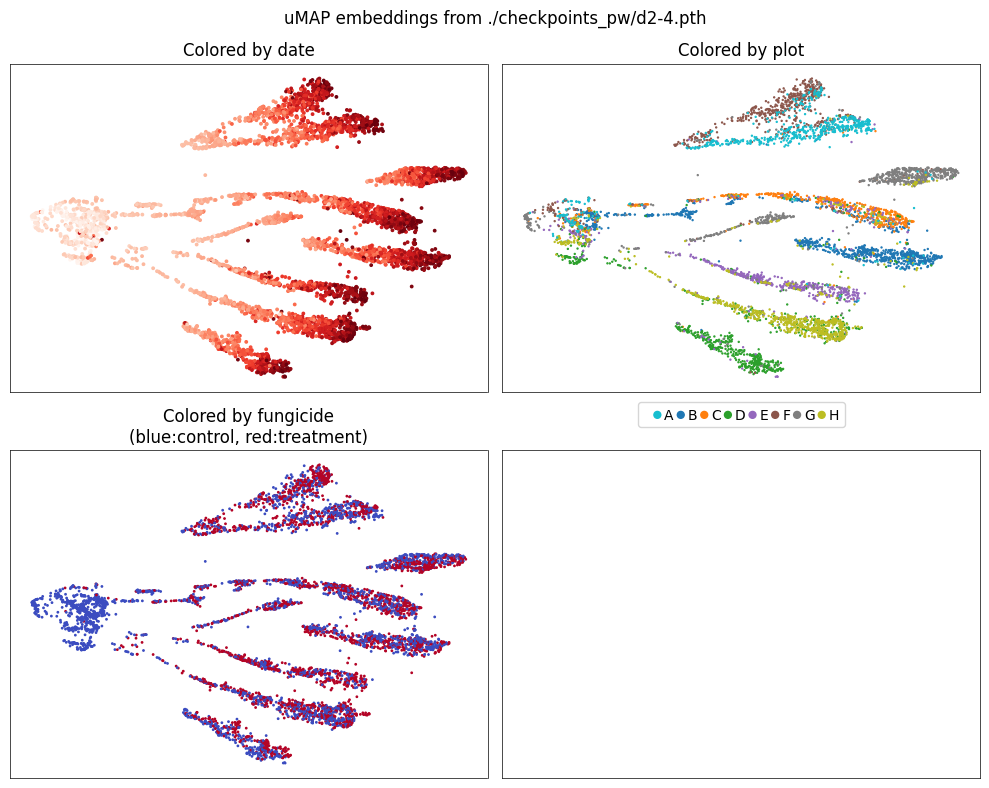

In [232]:
%matplotlib inline
relevant_rows = bog_2_patch_df.iloc[val_idxs]
# relevant_rows = val_rows[val_rows['plot'].isin(selected)]

date_codes = relevant_rows['date'].astype('category').cat.codes
plot_codes = relevant_rows['plot'].astype('category').cat.codes
plot_labels = list(relevant_rows['plot'])
fungicide_codes = relevant_rows['fungicide'].astype('category').cat.codes

date_c, _ = r_utils.values_to_colors(list(date_codes), cmap_name='Reds')
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')
fungicide_c, fclist = r_utils.values_to_colors(list(fungicide_codes), cmap_name='coolwarm')

fig_scale = 1
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(fig_scale*10,fig_scale*8))
axs = axs.flatten()
axs[0].scatter(*embedding.T, s=3, c=date_c)
axs[0].set_title("Colored by date")


axs[1].set_title("Colored by plot")
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    letter_label = r_utils.var_to_letter[label]
    # letter_label = label
    axs[1].scatter(
        embedding[i, 0], embedding[i, 1], label=letter_label, s=0.5, c=np.array(plot_c)[i]
    )

# sort legend
handles, labels = axs[1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[1].legend(
    sorted_handles, sorted_labels, markerscale=7,
    ncol=len(np.unique(plot_labels)),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.01),
    # bbox_to_anchor=(1.2, 1.0),
    # fontsize=28,
    handletextpad=-0.5, columnspacing=-0.5
)

axs[2].scatter(*embedding.T, s=1, c=fungicide_c)
axs[2].set_title("Colored by fungicide\n(blue:control, red:treatment)")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(f"uMAP embeddings from {checkpoint_name}")
plt.tight_layout()
plt.show()

# teaser figure

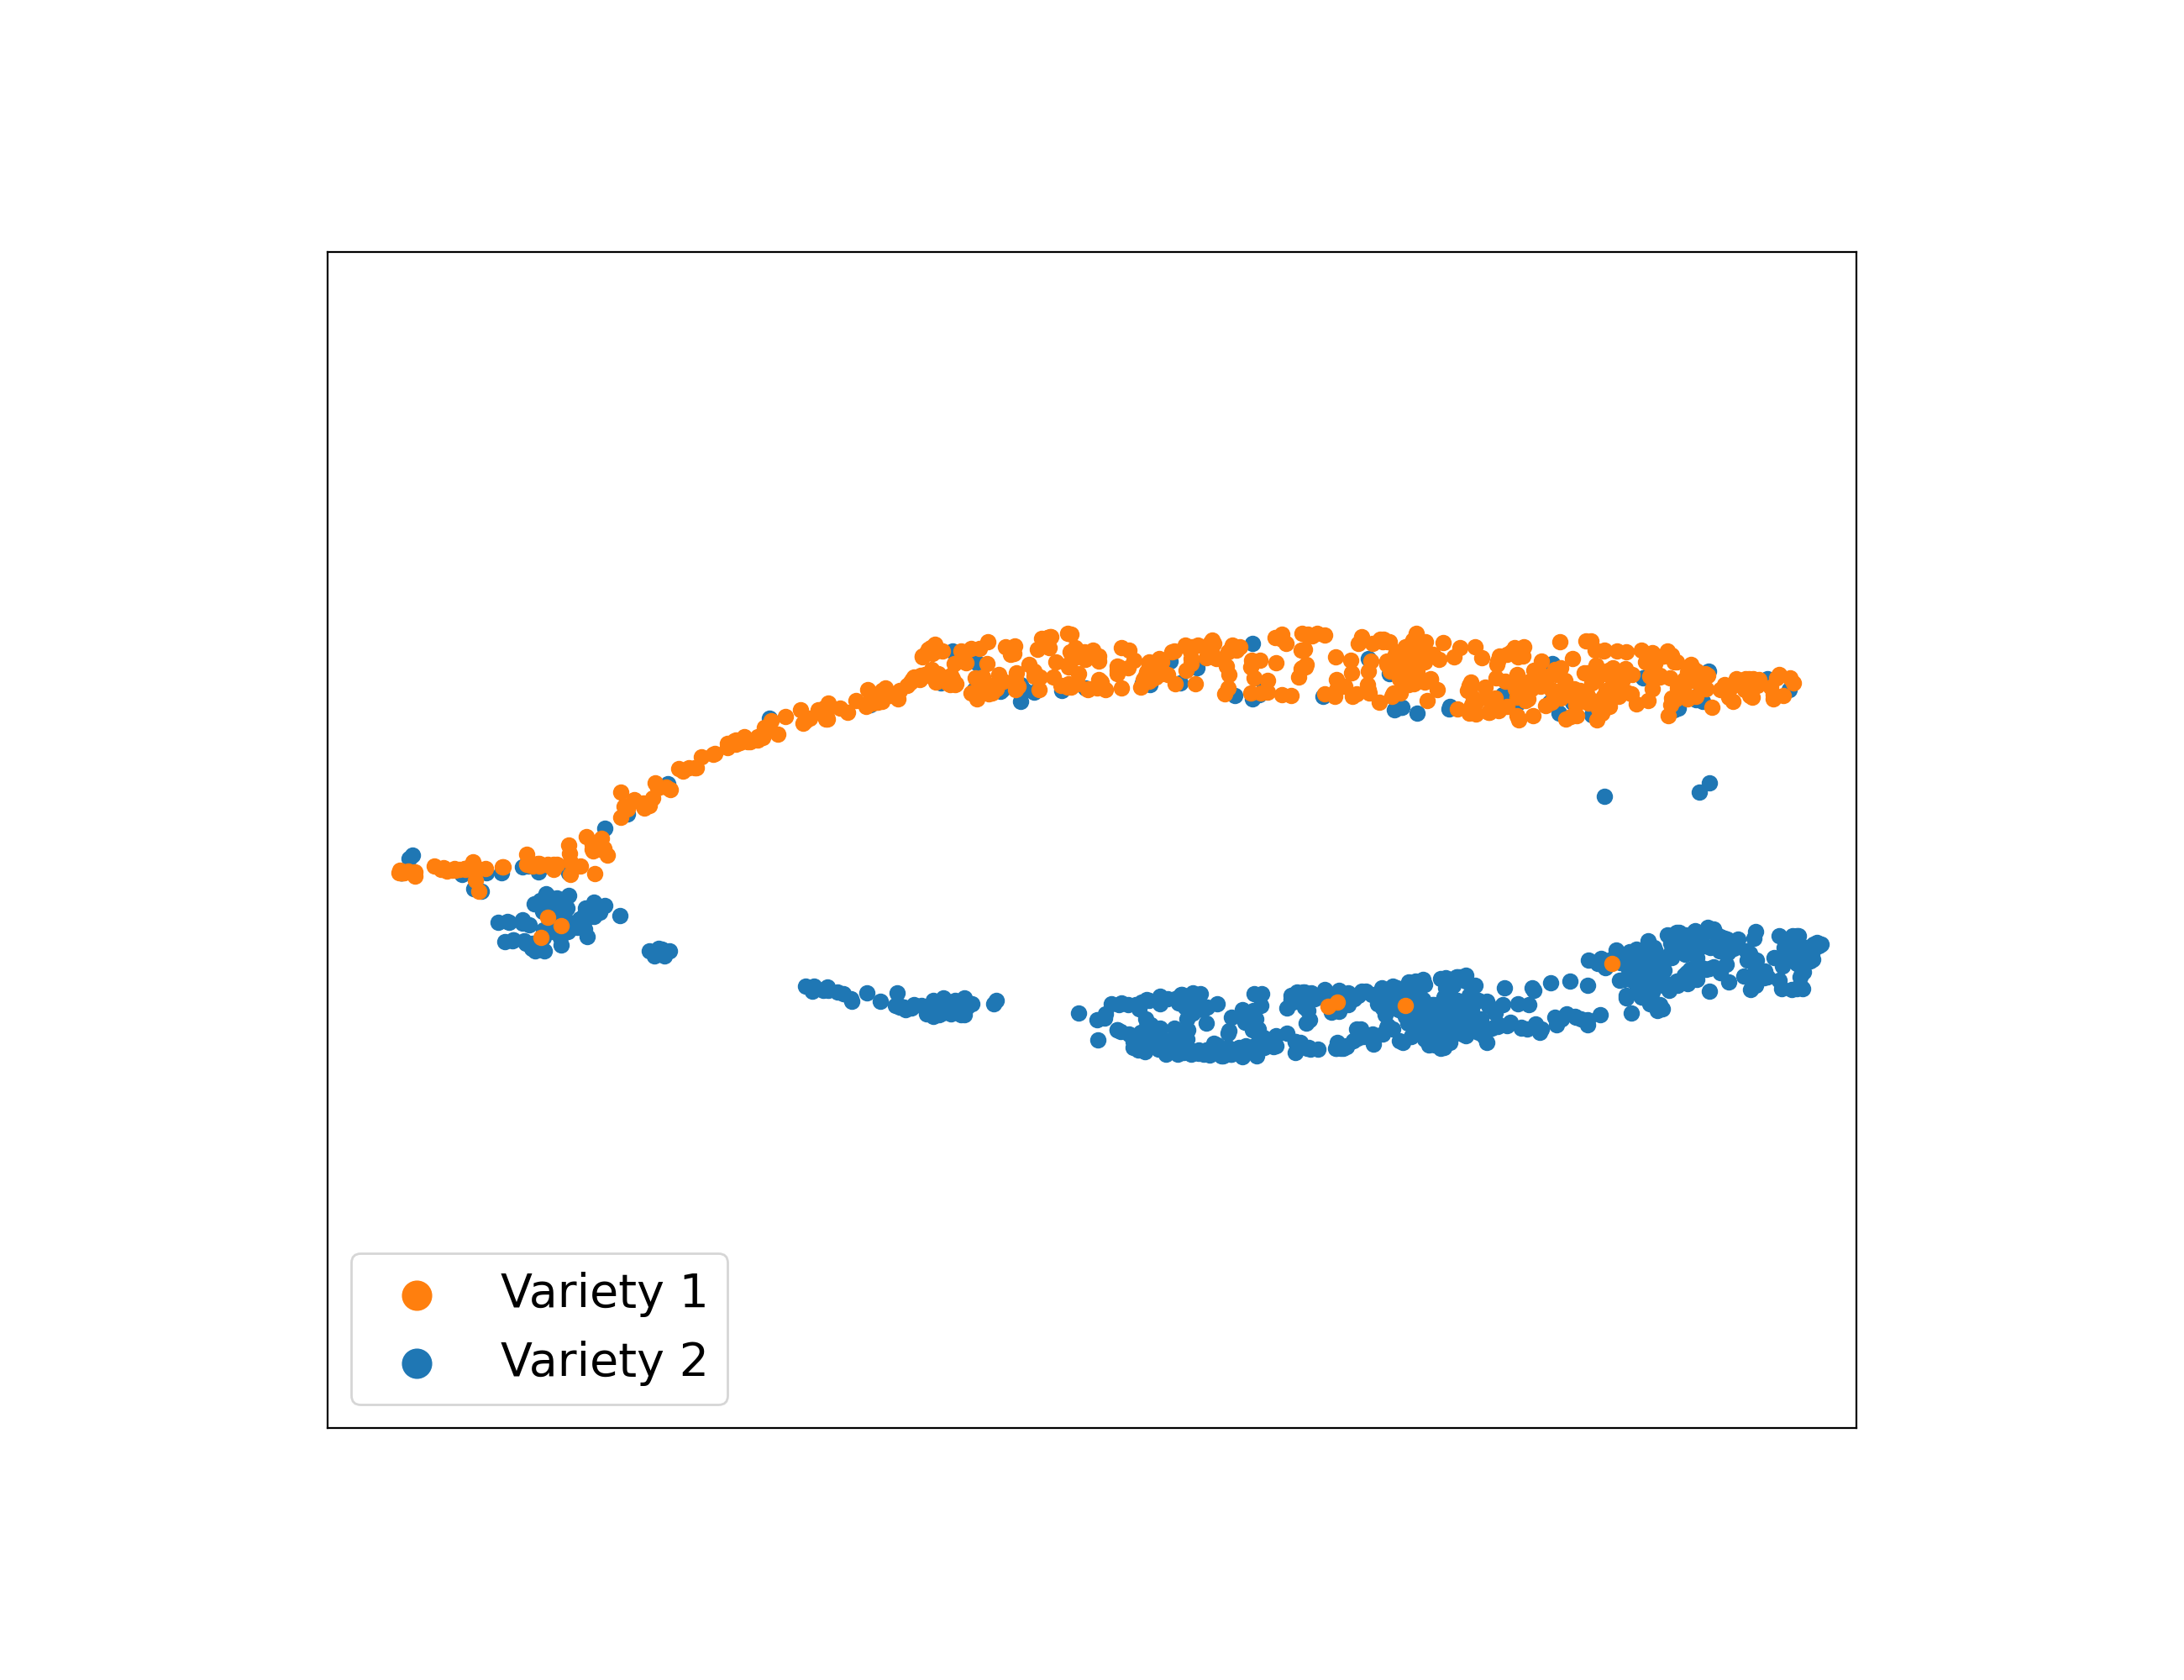

'selected image 1183'

'selected image 150'

'selected image 1197'

'selected image 1039'

'selected image 114'

In [ ]:
%matplotlib widget
from importlib import reload
reload(plotting_vis)

fig_scale=1.0
fig_size = (13, 10)
# plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=300)

# for label in np.unique(plot_labels):
#     i = np.where(np.array(plot_labels) == label)
#     letter_label = r_utils.var_to_letter[label]
#     # letter_label = label
#     plt.scatter(
#         embedding[i, 0], embedding[i, 1], label=letter_label, s=0.5, c=np.array(plot_c)[i]
#     )

indices = np.random.choice(embedding.shape[0], size=embedding.shape[0], replace=False, )
features_subset = np.array(embedding[indices])
rich_labels = relevant_rows[['plot', 'date', 'patch_coords', 'fungicide']].iloc[indices].to_dict(orient='list')
images = [val_dataset[sel_val_idxs[i]][0] for i in indices]

var_to_label = {
    'cnj05-73-39': 'Variety 1',
    'cnj14-31-142': 'Variety 2'
}

plot_labels = [var_to_label[l] for l in rich_labels['plot']]

plotting_vis.plot_with_annotations(features_subset, plot_labels, images, figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), cmap='tab10')

yscale = 1.4
xscale = 1.0
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim((xlim[0]*xscale, xlim[1]*xscale-0.5))
plt.ylim((ylim[0]*yscale-13, ylim[1]*yscale+9))

plt.xticks([])
plt.yticks([])
plt.show()

# print(rich_labels['plot'])
# print(plt.ylim())

# Full Width Figure

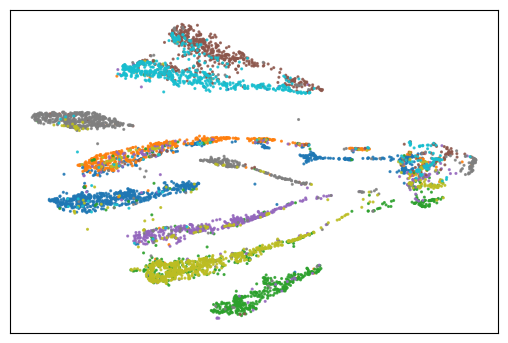

In [9]:
fig_scale=0.6
fig_size = (10.5, 7)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=100)

for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    letter_label = r_utils.var_to_letter[label]
    # letter_label = label
    plt.scatter(
        embedding[i, 0], embedding[i, 1], label=letter_label, s=1.5, alpha=0.8, c=np.array(plot_c)[i]
    )

ax = plt.gca()
ax.invert_xaxis()
plt.xticks([])
plt.yticks([])
plt.show()

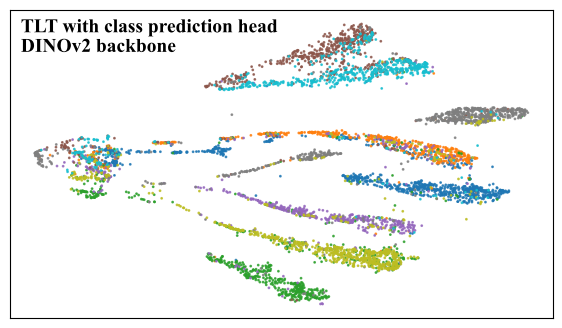

In [10]:
fig_scale=0.5
fig_size = (14, 8)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=100)

for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    letter_label = r_utils.var_to_letter[label]

    plt.scatter(
        embedding[i, 0], embedding[i, 1], label=letter_label, s=1.0, alpha=0.8, c=np.array(plot_c)[i]
    )

ax = plt.gca()
import matplotlib.patheffects as path_effects
ax.text(
    0.02, 0.97, 'TLT with class prediction head \nDINOv2 backbone',
    transform=ax.transAxes,     
    fontsize=14,
    verticalalignment='top',
    fontname='Times New Roman',
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ]
)  


plt.xticks([])
plt.yticks([])
# plt.savefig(f"../media/{checkpoint_name.split('/')[-1].split('.')[0]}_{fig_size[0]}_{fig_size[1]}_class_only.png", bbox_inches='tight',pad_inches=0.02)
plt.show()

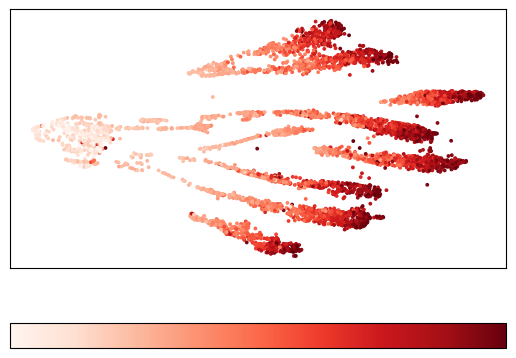

In [11]:
plt.figure(dpi=100)
# plt.scatter(*embedding.T, s=3, c=date_c)
plt.scatter(*embedding.T, s=3, c=date_c)
plt.xticks([])
plt.yticks([])

import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.Reds
norm = colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # needed for colorbar to work

cbar = plt.colorbar(sm, ax=plt.gca(), orientation='horizontal')
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
plt.show()

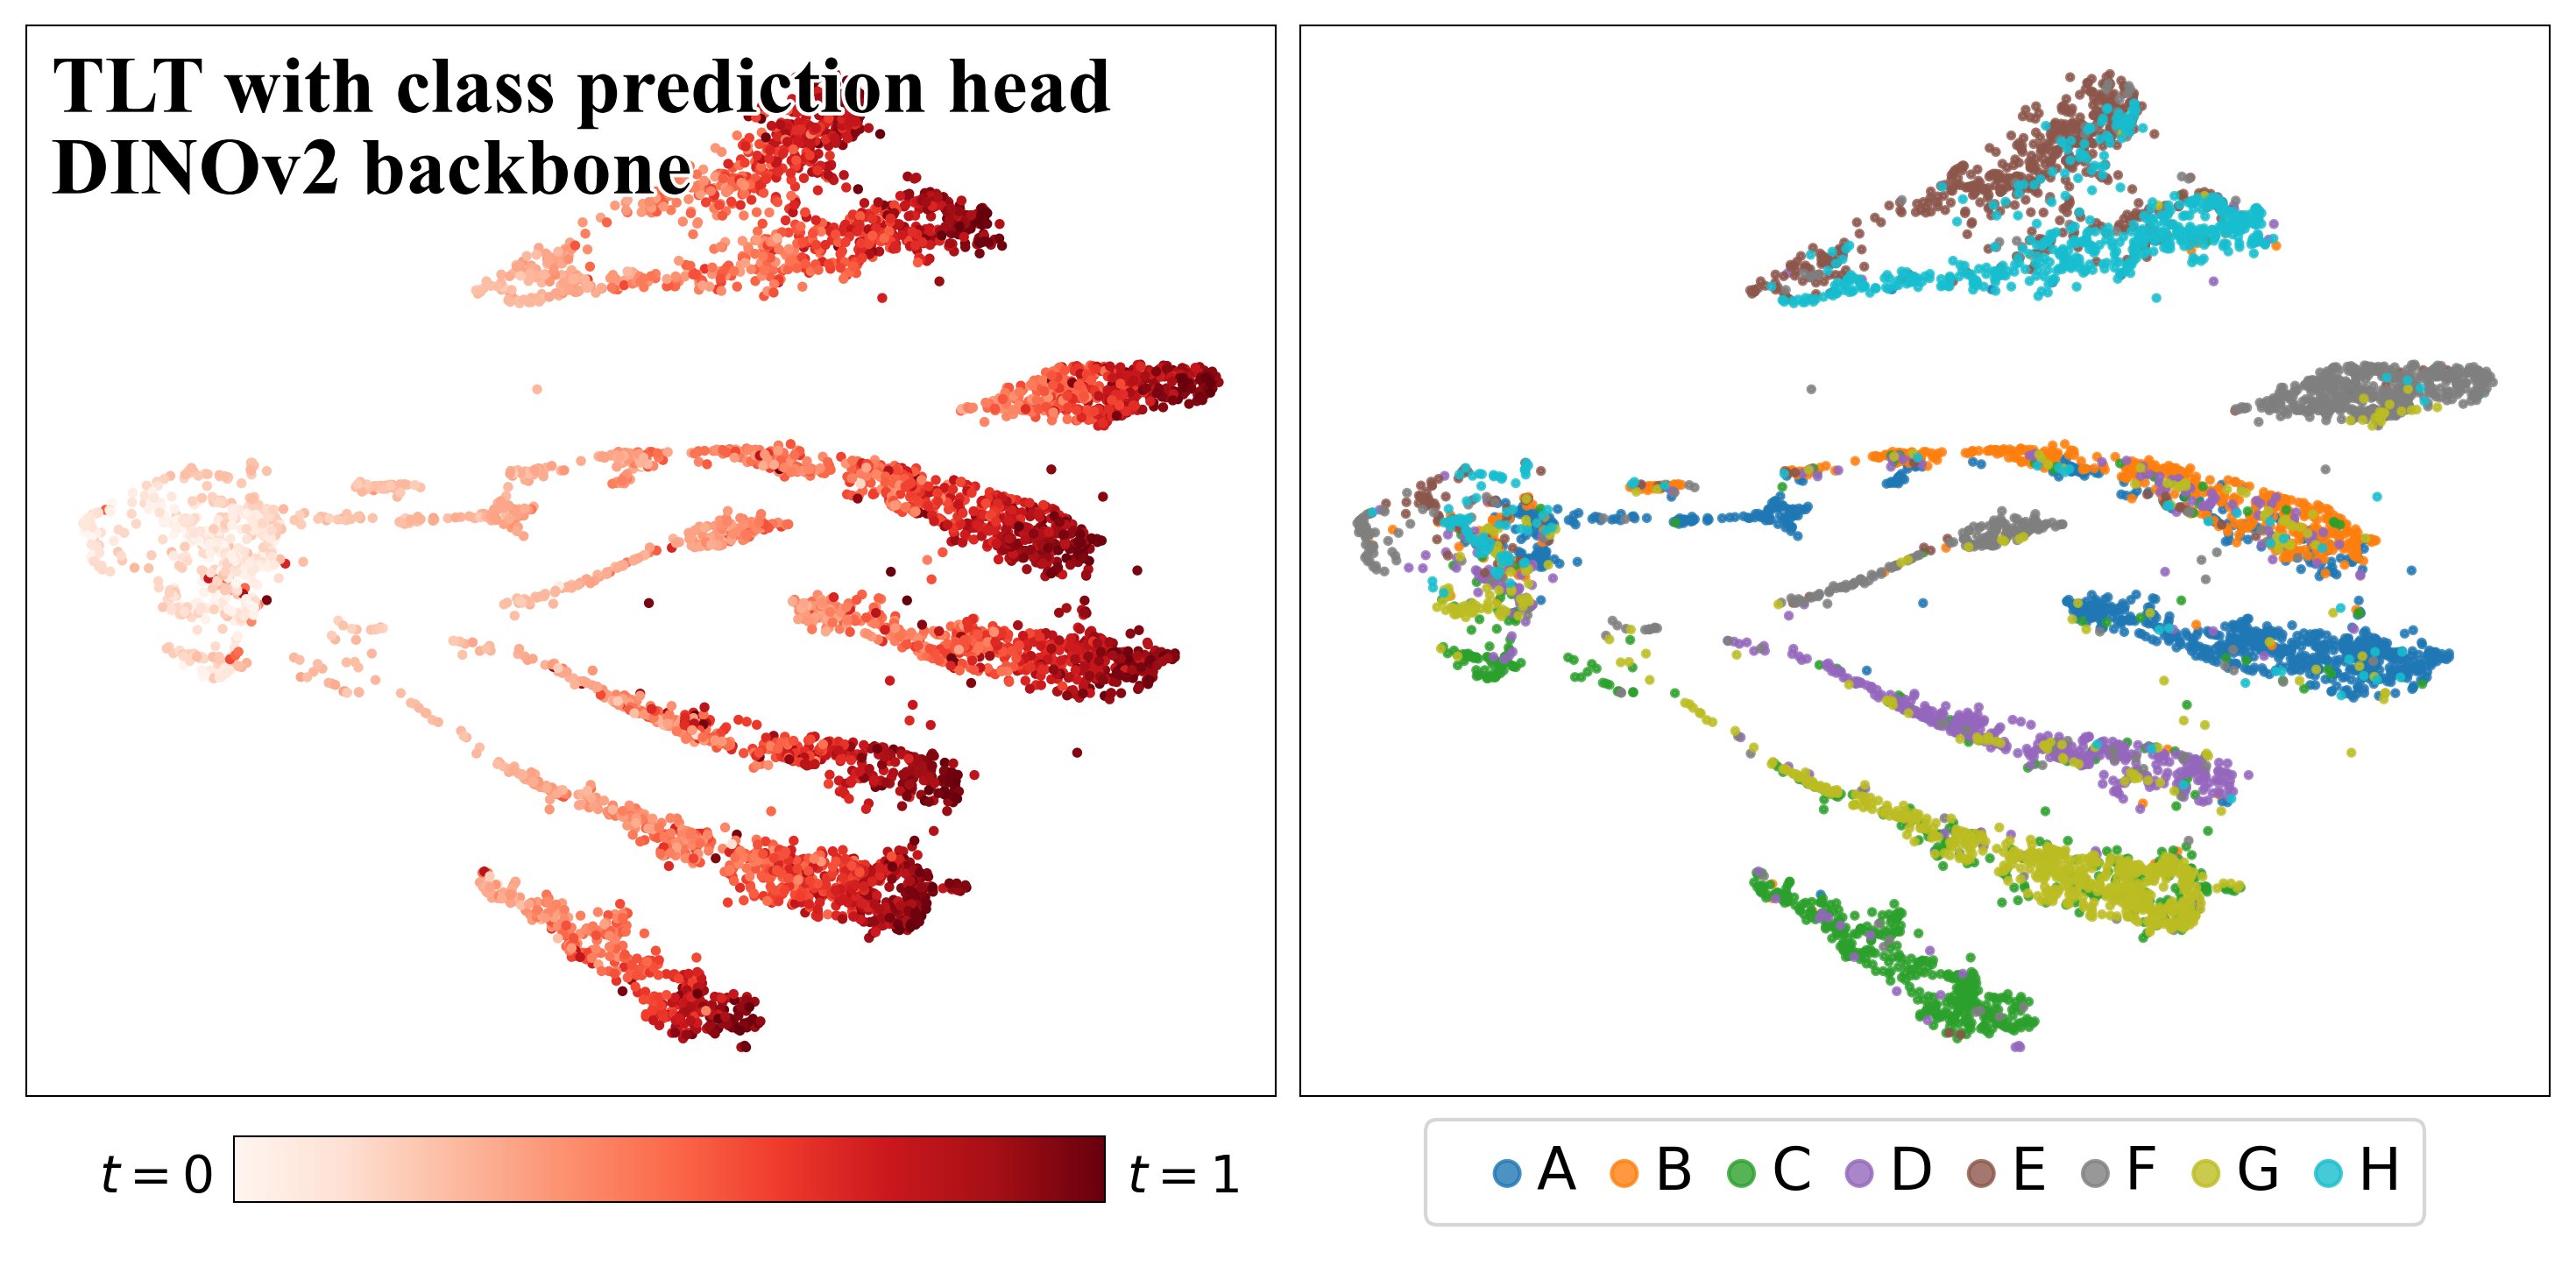

In [225]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams['path.simplify'] = False

fig_scale=0.5
fig_size = (18*1.1, 10)
fig, axs = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]),
    height_ratios=(0.95, 0.05),
    dpi=300,  # dpi=300 for saved version
)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs.flatten()[2:]:
    ax.axis('off')
    ax.axis('off')

# time colored
axs[0][0].scatter(*embedding.T, s=3.0, c=date_c, rasterized=True)
cmap = cm.Reds
norm = colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # needed for colorbar to work

pos = axs[0][0].get_position()
# cax = fig.add_axes([
#     pos.x0 + 0.045,
#     pos.y0 - 0.07,
#     pos.width * 0.8,
#     0.04
# ]) # good for no tight layout

cax = fig.add_axes([
    pos.x0 - 0.03,
    pos.y0 - 0.14,
    pos.width * 0.95,
    0.05
])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=[], pad=0.0, anchor=(0, 0))

cax.text(-0.155, pos.y0 + 0.16, r'$t=0$', ha='left', va='center', transform=cax.transAxes, fontsize=14)
cax.text(1.025, pos.y0 + 0.16, r'$t=1$', ha='left', va='center', transform=cax.transAxes, fontsize=14)

# variety colored
scatter_handles = []
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    letter_label = r_utils.var_to_letter[label]

    scatter_handles.append(axs[0][1].scatter(
        embedding[i, 0],
        embedding[i, 1],
        label=letter_label,
        s=3.0,
        alpha=0.8,
        c=np.array(plot_c)[i],
        rasterized=True
    ))

axs[1][1].legend(
    handles=scatter_handles,
    labels=selected_letters,
    loc='upper center',
    # bbox_to_anchor=(0, 1.5, 0.8, 1),
    bbox_to_anchor=(0.1, 1.5, 0.8, 1),
    fontsize=16,
    markerscale=4.0,
    # labelspacing=1.2,
    handletextpad=-0.5,
    ncol=len(selected_letters),
    mode='expand',
    borderaxespad=0.0,
)

axs[0][0].text(
    0.02, 0.97, 'TLT with class prediction head \nDINOv2 backbone',
    transform=axs[0][0].transAxes,     
    fontsize=22,
    verticalalignment='top',
    fontname='Times New Roman',
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ]
) 


plt.tight_layout()
plt.subplots_adjust(wspace=0.02)
plt.savefig('../media/all_geno_two_heads_rdots.svg', format='svg', dpi=300)
plt.show()

for umap compare heads

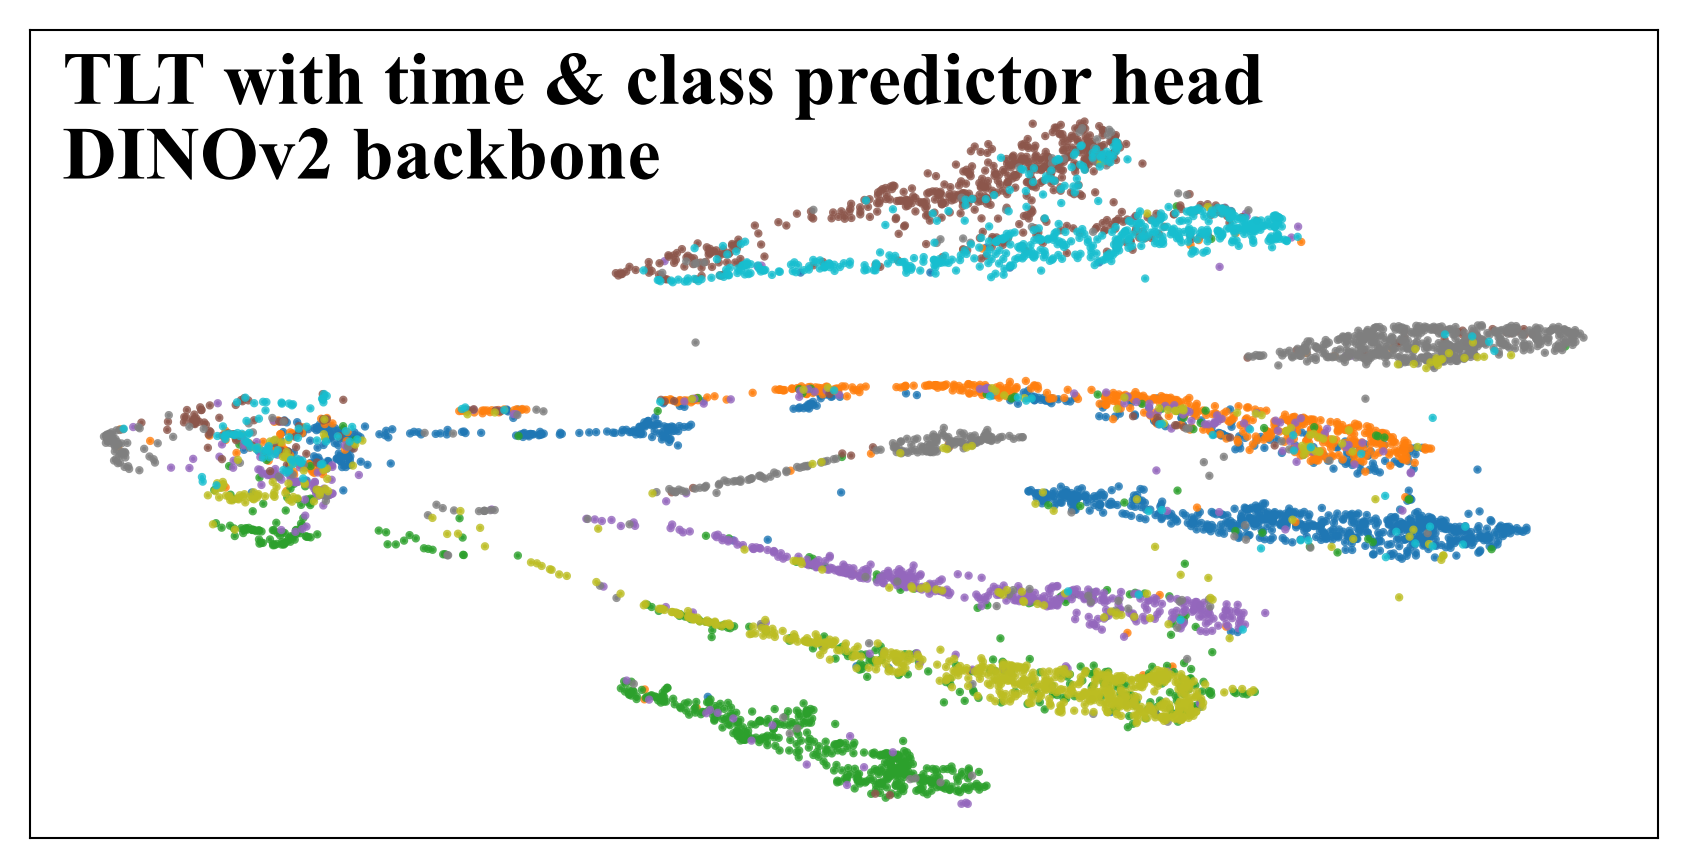

In [241]:
fig_scale=0.5
fig_size = (14, 7)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=300) # dpi=300 for saved version
ax = plt.gca()


scatter_handles = []
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    letter_label = r_utils.var_to_letter[label]

    scatter_handles.append(ax.scatter(
        embedding[i, 0],
        embedding[i, 1],
        label=letter_label,
        s=1,
        alpha=0.8,
        c=np.array(plot_c)[i],
        rasterized=True
    ))


ax.text(
    0.02, 0.97,
    f'TLT with time & class predictor head\n'+ \
    f'{r_utils.prettify_backbone_name(model.backbone_name)} backbone',
    transform=ax.transAxes,     
    fontsize=18,
    verticalalignment='top',
    fontname='Times New Roman',
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=4, foreground='white'),
        path_effects.Normal()
    ]
)

ylim = ax.get_ylim()
ax.set_ylim((ylim[0], ylim[1]+2))

plt.xticks([])
plt.yticks([])
plt.savefig('../media/umap_cmp_heads_2.svg')
plt.show()

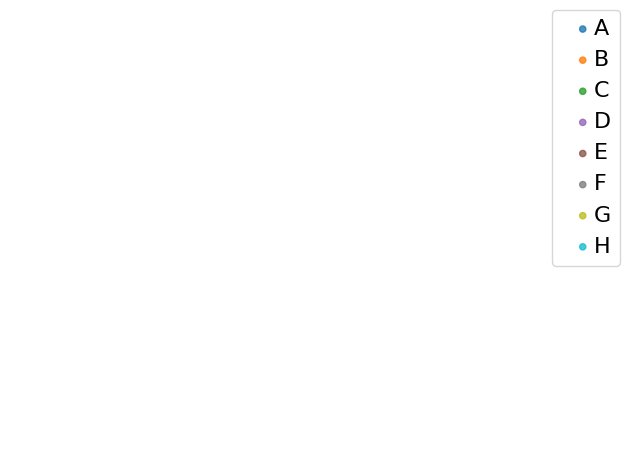

In [256]:
plt.figure()
ax = plt.gca()

ax.legend(
    handles=scatter_handles,
    labels=selected_letters,
    fontsize=16,
    markerscale=4.5,
    # labelspacing=1.2,
    handletextpad=-0.5,
    # ncol=len(selected_letters),
    # mode='expand',
    borderaxespad=0.0,
)

plt.axis('off')
plt.tight_layout()
plt.savefig('../media/vertical_legend.svg', format='svg')
plt.show()